In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

#from utils.helper import fn_plot_tf_hist

In [3]:
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:
###----------------------
### Some basic parameters
###----------------------


inpDir = 'C:/Users/Administrator.DAI-PC2/Documents/DNN/input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'
valDir = 'valid_flowers'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 5 # number of cycles to run
FLIP_MODE = 'horizontal_and_vertical'
ROTATION = (-0.1,0.1)
BATCH_SIZE = 8 # inline of Training Rows being 60000
IMG_HEIGHT = 200 #may vary
IMG_WIDTH = 200


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
print (physical_devices)

[]


Delete these lines

In [8]:
# labels = []
# for count, data in enumerate (train_ds):
#     imgs, lbls = data
#     #print(count, ':', imgs.shape, lbls.shape)
#     labels.append(lbls)
# tf.concat(labels,axis=0).numpy().shape
# unique, A, counts = tf.unique_with_counts(tf.concat(labels,axis=0).numpy())
# unique, A, counts

In [9]:
def fn_plot_label(tr_ds, ts_ds):  # def plot
    
    plt.figure(figsize = (15,5)) # instantiate the figure
    
    plt.subplot(1,2,1) # first out of 2

    train_labels = tf.concat([lbl for img, lbl in tr_ds], axis = 0).numpy() # get the labels code explained above

    unique, _, counts = tf.unique_with_counts(train_labels) # get counts code explained above

    plt.bar(range(len(unique)), counts, align='center', color = 'DarkBlue') # barplot the counts

    plt.xticks(range(len(unique)), class_names)

    plt.title('Training Set')

    plt.subplot(1,2,2)
    
    test_labels = tf.concat([lbl for img, lbl in ts_ds], axis = 0).numpy()

    unique, _, counts = tf.unique_with_counts(test_labels)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange')

    plt.xticks(range(len(unique)), class_names)

    plt.title('Test Set')


In [10]:
'''import pathlib -> remove comments if working on colab
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)'''


data_dir = os.path.join(inpDir, subDir)
data_dir

'C:/Users/Administrator.DAI-PC2/Documents/DNN/input\\flower_photos'

In [11]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [12]:
# create training data
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='training', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

# test data
test_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, # path the the data directory
    validation_split=TEST_SIZE, # what ratio of validation data
    subset='validation', # purpose
    seed=RANDOM_STATE, 
    image_size=[IMG_HEIGHT, IMG_WIDTH], ## @@@ WHAT!
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# is it picking class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [14]:
class_dict = {k: v for k,v in enumerate(class_names)}
class_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [15]:
n_classes = len(class_names)
n_classes

5

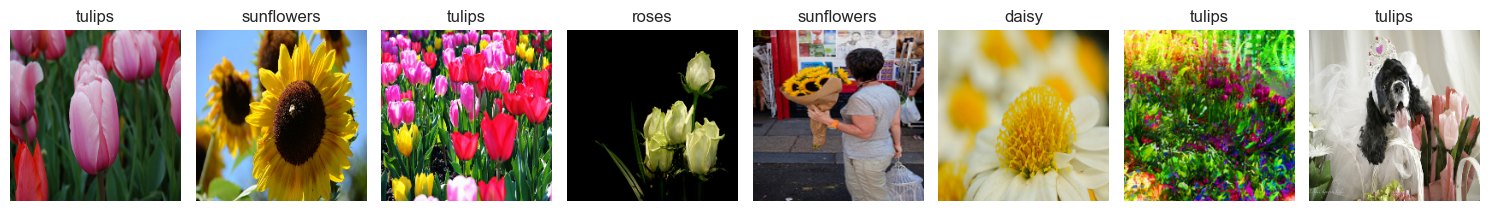

In [16]:
plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1):
    for i in range (BATCH_SIZE):
        plt.subplot(int(BATCH_SIZE/8), 8, i +1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

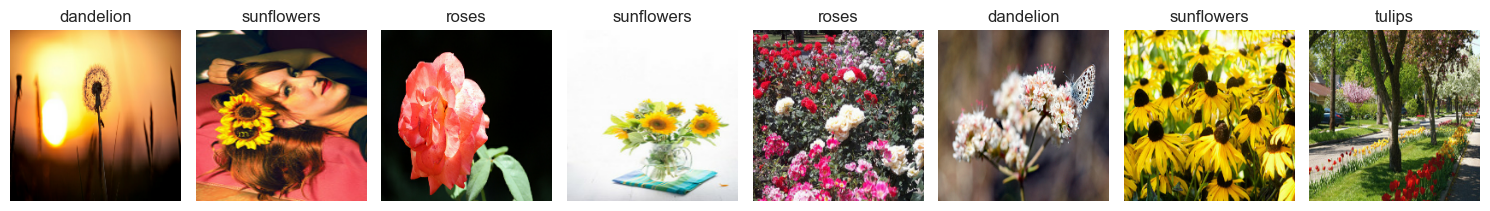

In [17]:
plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # get me one batch
    
    for i in range (BATCH_SIZE): # loop over batch
        
        plt.subplot(int(BATCH_SIZE/8), 8, i +1) # access the axis
        
        plt.grid(False) # no to grid
        
        plt.imshow(images[i].numpy().astype('uint8')) # show image convert to numpy and int
        
        plt.title(class_names[labels[i]])
        
        plt.axis('off')
    
    plt.tight_layout()

plt.show()

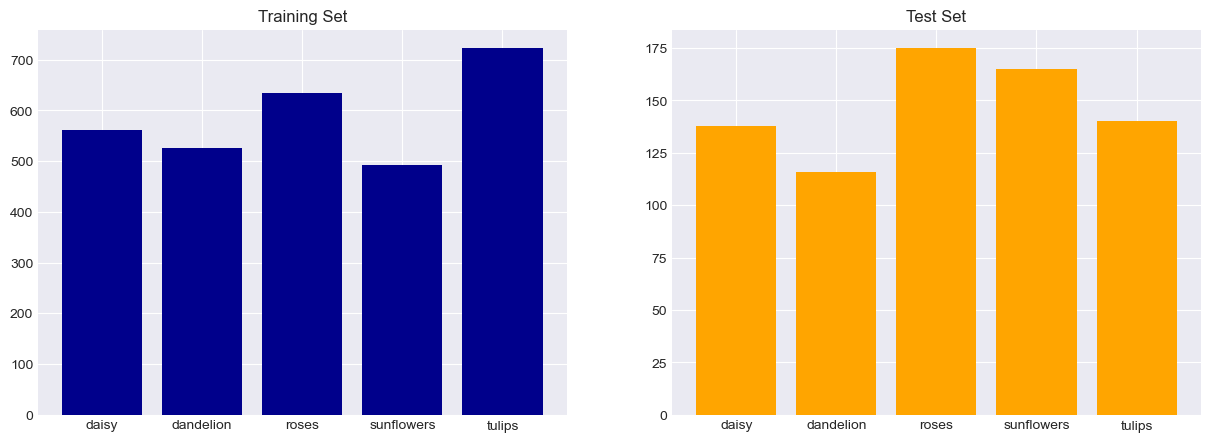

In [18]:
fn_plot_label(train_ds, test_ds)

In [19]:
train_ds= train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(200, 200, 3)

In [21]:
tf.keras.applications.DenseNet169?

In [22]:
densenet_model = tf.keras.applications.DenseNet169(weights = 'imagenet',
                                                    include_top=False,
                                                    input_shape=input_shape)

In [23]:
for layer in densenet_model.layers:
    layer.trainable = False

In [24]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, 50, 50, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 50, 50, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 50, 50, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 50, 50, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 25, 25, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 25, 25, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 12, 12, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 12, 12, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 12, 12, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 12, 12, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 12, 12, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 12, 12, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 12, 12, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 12, 12, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 12, 12, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 12, 12, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 12, 12, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 12, 12, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 12, 12, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 12, 12, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 12, 12, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 12, 12, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 12, 12, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 12, 12, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 12, 12, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 12, 12, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 12, 12, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 6, 6, 736)            2944      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 6, 6, 736)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 6, 6, 128)            94208     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_blo

 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 6, 6, 864)            3456      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 6, 6, 864)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 6, 6, 128)            110592    ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
          

 conv5_block11_concat (Conc  (None, 6, 6, 992)            0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 6, 6, 992)            3968      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 6, 6, 992)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 6, 6, 128)            126976    ['conv5_block12_0_relu[0][0]']
 2D)      

                                                                                                  
 conv5_block15_concat (Conc  (None, 6, 6, 1120)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 6, 6, 1120)           4480      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 6, 6, 1120)           0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_blo

 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 6, 6, 1248)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 6, 6, 1248)           4992      ['conv5_block19_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block20_0_relu (Acti  (None, 6, 6, 1248)           0         ['conv5_block20_0_bn[0][0]']  
 vation)                                                                                          
          

 conv5_block23_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 6, 6, 1376)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_block24_0_bn (BatchN  (None, 6, 6, 1376)           5504      ['conv5_block23_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block24_0_relu (Acti  (None, 6, 6, 1376)           0         ['conv5_block24_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv5_block27_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 6, 6, 1504)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
                                                                                                  
 conv5_block28_0_bn (BatchN  (None, 6, 6, 1504)           6016      ['conv5_block27_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 6, 6, 1632)           0         ['conv5_block30_concat[0][0]',
 atenate)                                                            'conv5_block31_2_conv[0][0]']
                                                                                                  
 conv5_block32_0_bn (BatchN  (None, 6, 6, 1632)           6528      ['conv5_block31_concat[0][0]']
 ormalization)                                                                                    
          

In [25]:
def build_model(input_shape, n_classes):
    kernel_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

    model = tf.keras.Sequential()

#Pre-processing
    model.add(tf.keras.layers.Rescaling(1./255.))
    
    #Augmentation Layers here!
    
    model.add(densenet_model)  #6 * 6 * 1664

#Head
    model.add(tf.keras.layers.Flatten())

#Dense 1
    model.add(tf.keras.layers.Dense(1664, kernel_initializer=kernel_init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

#Dense 2
    model.add(tf.keras.layers.Dense(46, kernel_initializer=kernel_init))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation(activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

#Dense 3
    model.add(tf.keras.layers.Dense(n_classes,kernel_initializer=kernel_init))

    return model

In [26]:
model = build_model(input_shape,n_classes)
model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# #Model callback
# checkpoint_path=os.path.join(modelDir,subDir,'Fashion_cnn')

# model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     verbose=2,
#     save_best_only=True,
#     save_weights_only=True,
#     mode='auto'
# )

# #EarlyStopping callback
# es_callback=tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=PATIENCE,
#     verbose=2,
#     baseline=None,
#     restore_best_weights=True
# )

# #Lr
# lr_callback=tf.keras.callbacks.ReduceLROnPlateau(
#                 monitor='val_loss',
#                 factor=FACTOR_LR,
#                 patience=LR_PATIENCE,
#                 verbose=1
#             )

In [29]:
history= model.fit(train_ds,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=test_ds)

Epoch 1/5


367/367 [==============================] - 344s 887ms/step - loss: 0.8128 - accuracy: 0.7119 - val_loss: 0.3529 - val_accuracy: 0.8747
Epoch 2/5
367/367 [==============================] - 315s 858ms/step - loss: 0.4199 - accuracy: 0.8699 - val_loss: 0.3234 - val_accuracy: 0.8815
Epoch 3/5
367/367 [==============================] - 312s 850ms/step - loss: 0.2779 - accuracy: 0.9159 - val_loss: 0.3326 - val_accuracy: 0.8787
Epoch 4/5
367/367 [==============================] - 315s 858ms/step - loss: 0.1931 - accuracy: 0.9479 - val_loss: 0.3387 - val_accuracy: 0.8815
Epoch 5/5
367/367 [==============================] - 314s 855ms/step - loss: 0.1425 - accuracy: 0.9591 - val_loss: 0.3046 - val_accuracy: 0.8978


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 59904)             0         
                                                                 
 dense (Dense)               (None, 1664)              99681920  
                                                                 
 batch_normalization (Batch  (None, 1664)              6656      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1664)              0         
                                                        

In [31]:
# tf.keras.utils.plot_model(model,'model.png',
#                         show_shapes=True,
#                          show_dtype=True,
#                          dpi=96,
#                          show_layer_activations=True)


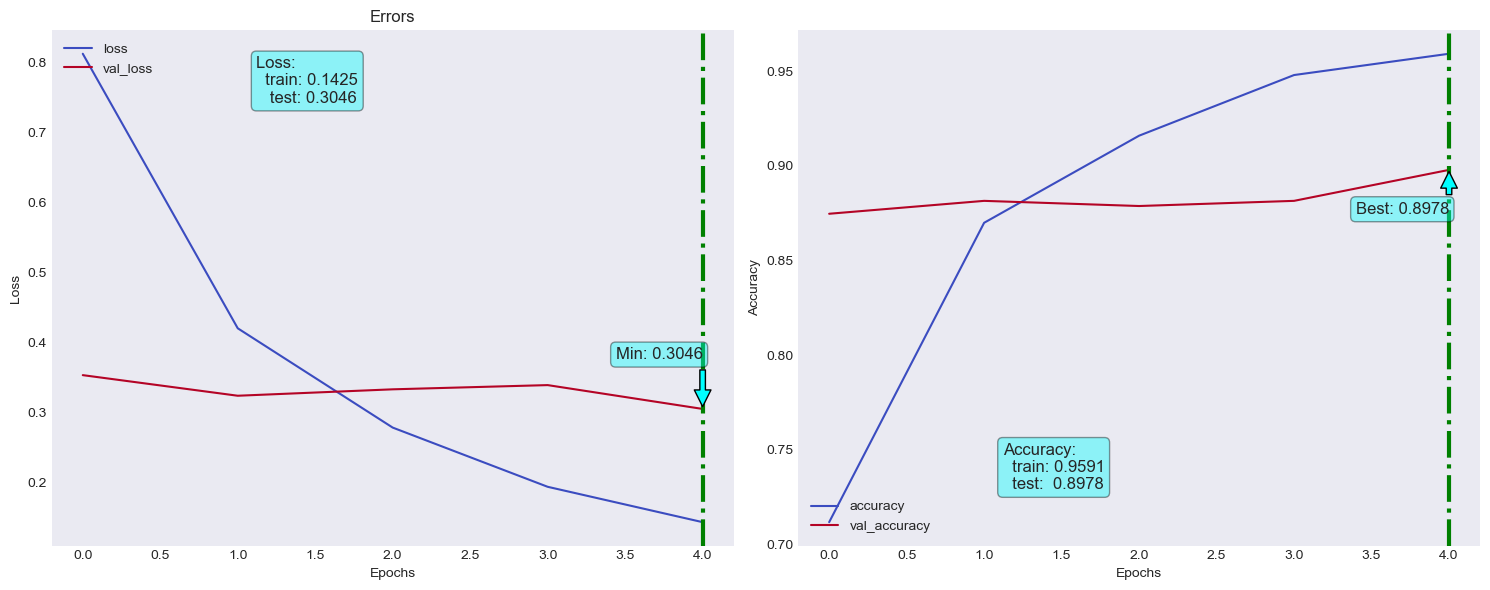

In [32]:
 fn_plot_tf_hist(pd.DataFrame(history.history))

In [33]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

92/92 [==============================] - 24s 259ms/step - loss: 0.3046 - accuracy: 0.8978


In [34]:
yhat = model.predict(test_ds)
y_test = np.concatenate([y for X, y in test_ds], axis=0).squeeze()

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.4f}'.format(accuracy_score(y_test,y_pred)))

92/92 [==============================] - 29s 269ms/step
Accuracy score on Test Data : 0.8978


# Running on Validation Data

In [35]:
val_dir = os.path.join(inpDir, valDir)

val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                    validation_split=None,
                                                    seed=RANDOM_STATE,
                                                    image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE)

Found 231 files belonging to 5 classes.


In [36]:
test_loss, test_acc = model.evaluate(val_ds, verbose=1)

29/29 [==============================] - 8s 279ms/step - loss: 0.4962 - accuracy: 0.8571


In [37]:
yhat = model.predict(val_ds)
y_test = np.concatenate([y for X, y in val_ds], axis=0).squeeze()

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Valid Data : {:.4f}'.format(accuracy_score(y_test,y_pred)))

29/29 [==============================] - 8s 272ms/step
Accuracy score on Valid Data : 0.2121
